<a href="https://colab.research.google.com/github/Aditya-Poli/Fake-news-detection/blob/dev/dl_bi_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns 
plt.style.use('ggplot')

Read the data 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Processing

## Data Cleaning

In [3]:
fake = f"/content/drive/MyDrive/EC3M2/fake-and-real-news-dataset/Fake.csv"
true = f"/content/drive/MyDrive/EC3M2/fake-and-real-news-dataset/True.csv"

In [4]:
df = pd.read_csv(fake)
df['label'] = 0
df1 = pd.read_csv(true)
df1['label'] = 1
df = pd.concat([df, df1])
df.head(5)

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [5]:
df.tail(5)

,title,text,subject,date,label
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1
21416,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017",1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [7]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:


stop = stopwords.words('english')
df['title'] = df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’s...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian C...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke ...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name ...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Duri...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [9]:
X, y = df['title'], df['label']
X_text, y_text = df['text'], df['label']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=35)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=35)

In [11]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_text, y_text, test_size=0.4, random_state=35)
X_text_val, X_text_test, y_text_val, y_text_test = train_test_split(X_text_test, y_text_test, test_size=0.5, random_state=35)

## Normalizing our data: lower case, get rid of extra spaces, and url links. 

In [12]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [13]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

## Convert text to vectors, our classifier only takes numerical data. 

In [14]:
# tokenize the text into vectors 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [15]:
X_val = tokenizer.texts_to_sequences(X_val)

## Apply padding so we have the same length for each article 

In [16]:
sent_length= 256

In [17]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=sent_length)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=sent_length)
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, padding='post', maxlen=sent_length)

In [20]:
import pickle

In [21]:
with open('/content/drive/MyDrive/EC3M2/out/models/tokenizer_data.pkl', 'wb') as handle:
    pickle.dump(
        {'tokenizer': tokenizer, 'num_words':max_vocab, 'maxlen':sent_length}, handle)

#**Building the Bi-LSTM.**

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        49664     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

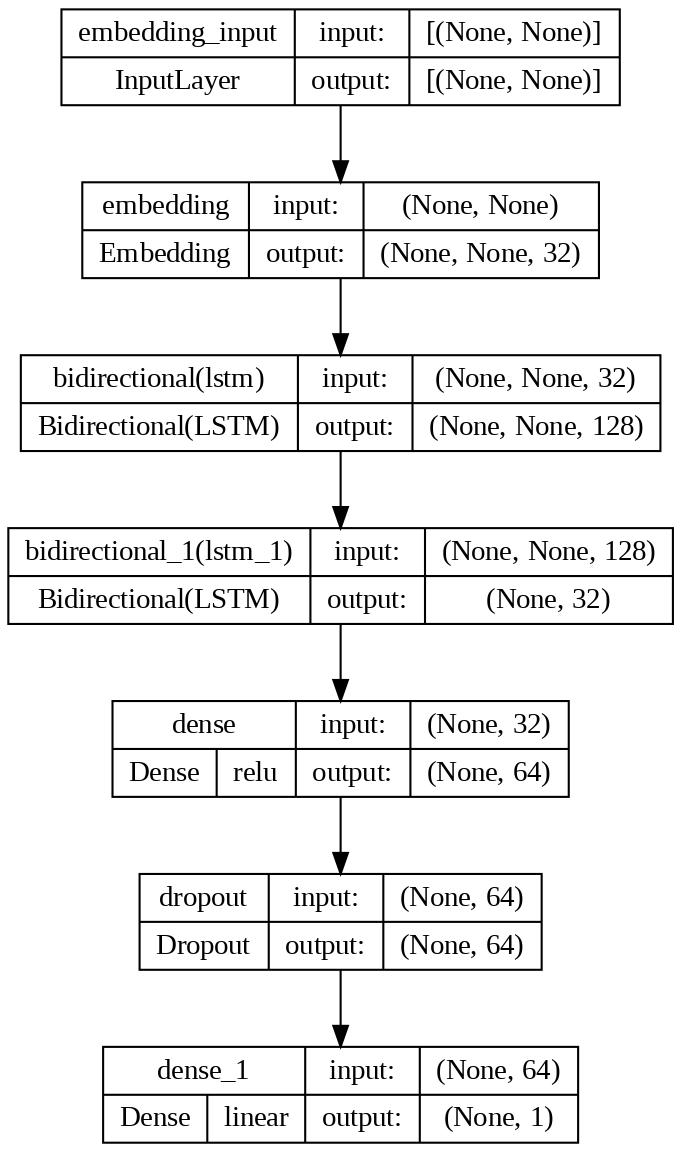

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/EC3M2/out/artifacts/bilstm.jpg', show_shapes=True, dpi=150, show_layer_activations=True)

**We are going to use early stop, which stops when the validation loss no longer improve.**

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
809/809 [==============================] - 71s 70ms/step - loss: 0.2736 - accuracy: 0.8735 - val_loss: 0.0878 - val_accuracy: 0.9748
Epoch 2/10
809/809 [==============================] - 37s 46ms/step - loss: 0.0732 - accuracy: 0.9806 - val_loss: 0.0629 - val_accuracy: 0.9788
Epoch 3/10
809/809 [==============================] - 29s 36ms/step - loss: 0.0486 - accuracy: 0.9871 - val_loss: 0.0699 - val_accuracy: 0.9803
Epoch 4/10
809/809 [==============================] - 28s 35ms/step - loss: 0.0374 - accuracy: 0.9905 - val_loss: 0.0620 - val_accuracy: 0.9762
Epoch 5/10
809/809 [==============================] - 28s 35ms/step - loss: 0.0294 - accuracy: 0.9922 - val_loss: 0.0714 - val_accuracy: 0.9655
Epoch 6/10
809/809 [==============================] - 30s 37ms/step - loss: 0.0227 - accuracy: 0.9940 - val_loss: 0.0522 - val_accuracy: 0.9826
Epoch 7/10
809/809 [==============================] - 28s 35ms/step - loss: 0.0168 - accuracy: 0.9958 - val_loss: 0.0677 - val_accuracy:

**Visualize our training over time**

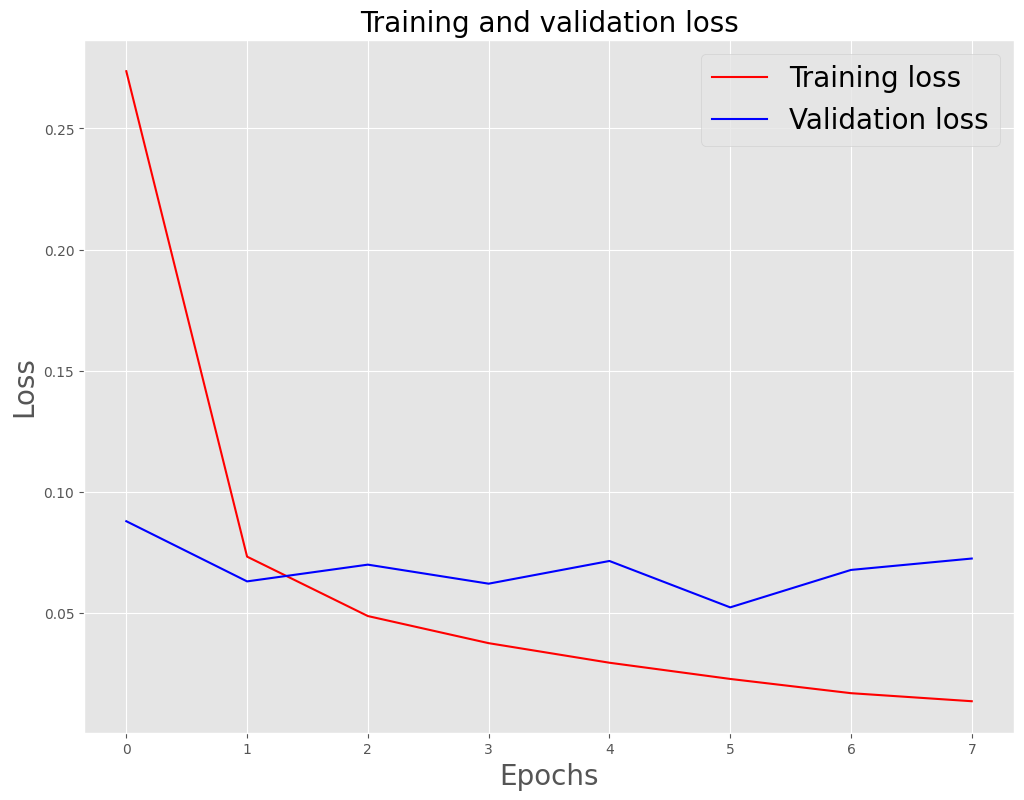

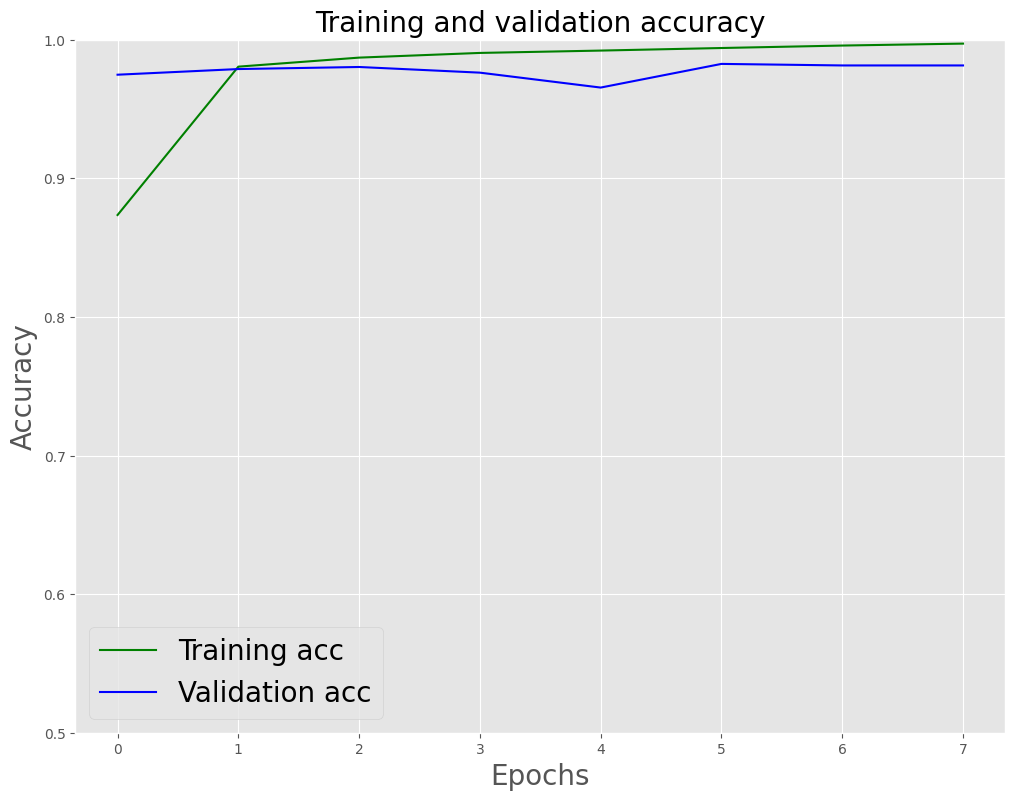

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.savefig('/content/drive/MyDrive/EC3M2/out/artifacts/tvlbilstm.jpg')
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.savefig('/content/drive/MyDrive/EC3M2/out/artifacts/tvabilstm.jpg')
plt.show()

**Evaluate the testing set**

In [ ]:
model.evaluate(X_test, y_test)

281/281 [==============================] - 4s 16ms/step - loss: 0.0731 - accuracy: 0.9825


[0.0731029361486435, 0.9825167059898376]

In [ ]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

281/281 [==============================] - 5s 13ms/step


In [ ]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9825167037861915
Precision on testing set: 0.9850285171102662
Recall on testing set: 0.9778249587166785


**Confusion matrix**

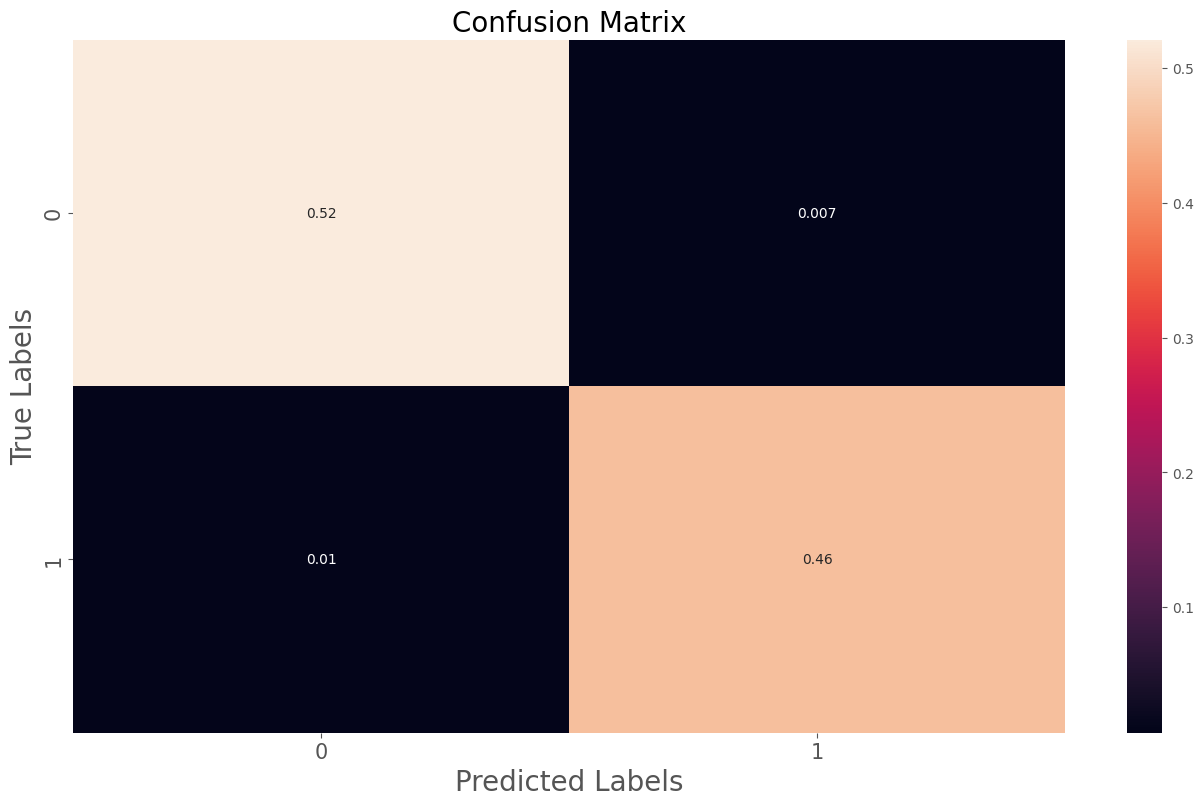

In [ ]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)
plt.savefig('/content/drive/MyDrive/EC3M2/out/artifacts/cm/bilstm.jpg', dpi=150)

**Saves the weights for visualiation**

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 32)


In [ ]:
word_index = list(tokenizer.word_index.keys())
word_index = word_index[:max_vocab-1]

Write to file so we can use tensorflow's embedding projector to visualize what our network learned. This is only based on the fake news dataset. 

In [ ]:
import time
import random
def avgTime(model:'Object',test_input:'numpy.ndarray') -> float:
    start = time.time()
    (model.predict(test_input)>0.5)*1
    end = time.time()
    print(avgtime:=((end-start)/(test_input.shape[0]))," s  |  ", avgtime*1000," ms  |  ", avgtime*1000000, " µs")
    return avgtime

In [ ]:
#RNN Processing Time
avgTime(model, X_test)

130/130 [==============================] - 2s 13ms/step
0.00042541221930430487  s  |   0.4254122193043049  ms  |   425.41221930430487  µs


0.00042541221930430487

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, (model.predict(X_test))>0.5)*1)

281/281 [==============================] - 5s 19ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4772
           1       0.98      0.99      0.98      4208

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



In [ ]:
import pickle
pickle.dump(model, open('/content/drive/MyDrive/EC3M2/out/models/bilstm.sav','wb'))